In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import cv2
import numpy as np
from skimage import transform as trans
import matplotlib.pyplot as plt

In [2]:
class FacePreprocessor:
    def __init__(self,image_size='112,112',margin=44):
        self.image_size = [int(x) for x in image_size.split(',')]
        if len(self.image_size) == 1:
            self.image_size = [self.image_size[0],self.image_size[0]]
        self.margin = margin
        assert len(self.image_size) == 2
        assert self.image_size[0] == 112 and (self.image_size[1] == 112 or self.image_size[1] == 96)
    def read_image(self,img_path,mode='rgb',layout='HWC'):
        if mode == 'gray': # gray -> gray
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if mode == 'rgb':
                img = img[..., ::-1]
            if layout == 'CHW':
                img = np.transpose(img,(2,0,1))
        return img
    def preprocess(self, img, bbox=None, landmark=None):
        if isinstance(img, str):
            img = self.read_image(img)

        M = None
        if landmark is not None:
            assert len(self.image_size) == 2
            src = np.array([
                [30.2946, 51.6963],
                [65.5318, 51.5014],
                [48.0252, 71.7366],
                [33.5493, 92.3655],
                [62.7299, 92.2041]], dtype=np.float32)

            if self.image_size[1] == 112:
                src[:, 0] += 8.0
            dst = landmark.astype(np.float32)

            tform = trans.SimilarityTransform()
            tform.estimate(dst, src)
            M = tform.params[0:2, :]

        if M is None:
            return self._center_crop(img, bbox)
        else:
            return self._warp_image(img, M)

    def _center_crop(self, img, bbox):
        if bbox is None:
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1] * 0.0625)
            det[1] = int(img.shape[0] * 0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
            det = bbox

        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0] - self.margin // 2, 0)
        bb[1] = np.maximum(det[1] - self.margin // 2, 0)
        bb[2] = np.minimum(det[2] + self.margin // 2, img.shape[1])
        bb[3] = np.minimum(det[3] + self.margin // 2, img.shape[0])

        ret = img[bb[1]:bb[3], bb[0]:bb[2], :]
        if len(self.image_size) > 0:
            ret = cv2.resize(ret, (self.image_size[1], self.image_size[0]))
        return ret

    def _warp_image(self, img, M):
        assert len(self.image_size) == 2
        warped = cv2.warpAffine(img, M, (self.image_size[1], self.image_size[0]), borderValue=0.0)
        return warped


In [8]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.0 MB/s eta 0:00:00


In [9]:
detector = MTCNN()

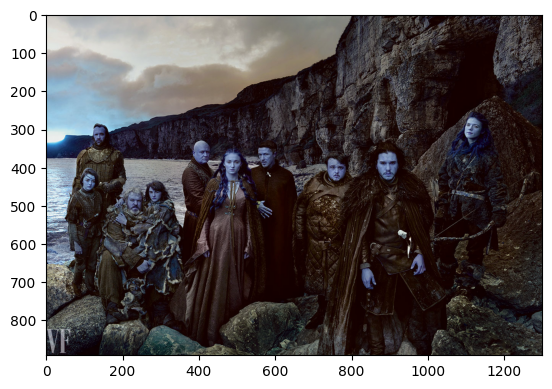

In [14]:
img = cv2.imread("/content/drive/MyDrive/coconut/small_datasets/test/001.jpg")
plt.imshow(img)

In [15]:
bboxes = detector.detect_faces(img)
bboxes

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[{'box': [1099, 271, 42, 53],
  'confidence': 0.9999998211860657,
  'keypoints': {'left_eye': (1107, 290),
   'right_eye': (1126, 294),
   'nose': (1112, 300),
   'mouth_left': (1105, 311),
   'mouth_right': (1120, 313)}},
 {'box': [742, 383, 43, 53],
  'confidence': 0.999993622303009,
  'keypoints': {'left_eye': (752, 402),
   'right_eye': (772, 403),
   'nose': (761, 413),
   'mouth_left': (753, 425),
   'mouth_right': (768, 425)}},
 {'box': [98, 422, 29, 38],
  'confidence': 0.9999480843544006,
  'keypoints': {'left_eye': (109, 436),
   'right_eye': (123, 438),
   'nose': (116, 445),
   'mouth_left': (108, 451),
   'mouth_right': (119, 453)}},
 {'box': [393, 345, 36, 44],
  'confidence': 0.9999112486839294,
  'keypoints': {'left_eye': (409, 361),
   'right_eye': (425, 362),
   'nose': (421, 370),
   'mouth_left': (410, 379),
   'mouth_right': (424, 379)}},
 {'box': [868, 364, 53, 67],
  'confidence': 0.9999012351036072,
  'keypoints': {'left_eye': (883, 390),
   'right_eye': (908, 3

{'left_eye': (1107, 290), 'right_eye': (1126, 294), 'nose': (1112, 300), 'mouth_left': (1105, 311), 'mouth_right': (1120, 313)}
[[1107  290]
 [1126  294]
 [1112  300]
 [1105  311]
 [1120  313]]
{'left_eye': (752, 402), 'right_eye': (772, 403), 'nose': (761, 413), 'mouth_left': (753, 425), 'mouth_right': (768, 425)}
[[752 402]
 [772 403]
 [761 413]
 [753 425]
 [768 425]]
{'left_eye': (109, 436), 'right_eye': (123, 438), 'nose': (116, 445), 'mouth_left': (108, 451), 'mouth_right': (119, 453)}
[[109 436]
 [123 438]
 [116 445]
 [108 451]
 [119 453]]
{'left_eye': (409, 361), 'right_eye': (425, 362), 'nose': (421, 370), 'mouth_left': (410, 379), 'mouth_right': (424, 379)}
[[409 361]
 [425 362]
 [421 370]
 [410 379]
 [424 379]]
{'left_eye': (883, 390), 'right_eye': (908, 390), 'nose': (896, 406), 'mouth_left': (886, 418), 'mouth_right': (906, 418)}
[[883 390]
 [908 390]
 [896 406]
 [886 418]
 [906 418]]
{'left_eye': (131, 315), 'right_eye': (146, 315), 'nose': (137, 324), 'mouth_left': (132, 

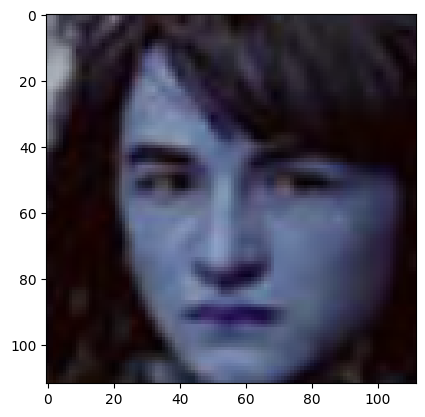

In [20]:
preprocessor = FacePreprocessor(image_size='112,112',margin=44)
if len(bboxes) != 0:
    for bboxe in bboxes:
        bbox = bboxe['box']
        bbox = np.array([bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]])      # Frame ของหน้า
        landmarks = bboxe['keypoints']
        print(landmarks)
        landmarks = np.array([                                                  # Extract landmark keypoint
            landmarks["left_eye"][0],
            landmarks["right_eye"][0],
            landmarks["nose"][0],
            landmarks["mouth_left"][0],
            landmarks["mouth_right"][0],
            landmarks["left_eye"][1],
            landmarks["right_eye"][1],
            landmarks["nose"][1],
            landmarks["mouth_left"][1],
            landmarks["mouth_right"][1]
        ])
        # print(landmarks)
        landmarks = landmarks.reshape((2,5)).T
        print(landmarks)
        nimg = preprocessor.preprocess(img,bbox,landmarks)
        plt.imshow(nimg)